# Análisis preliminar de los datos:

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from wordcloud import WordCloud
from collections import Counter
from sklearn.decomposition import PCA
import re
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
color_palette = sns.color_palette()

# Entrenamiento modelos:

Creamos el dataset df_final que contendrá toda la información: interacción de los tweets, sentiment analysis, word embedding y promedios ponderados por interacción

In [106]:
df = pd.read_csv("../data_reserva/features_dataset.csv")
df_encuestas = pd.read_csv("../data_reserva/encuesta.csv")

In [107]:
df["date"] = pd.to_datetime(df["date"])
df_encuestas["date"] = pd.to_datetime(df_encuestas["date"])

df["week_start"] = df["date"] - pd.to_timedelta((df["date"].dt.weekday + 1) % 7, unit="D")
df_encuestas["week_start"] = df_encuestas["date"] - pd.to_timedelta((df_encuestas["date"].dt.weekday + 1) % 7, unit="D")

df_weekly = df.groupby("week_start").mean(numeric_only=True).reset_index()
df_encuestas_sem = df_encuestas[["week_start", "aprobacion_boric"]].drop_duplicates()

df_final = df_weekly.merge(df_encuestas_sem, on="week_start", how="left").dropna()

df_final["approval_rolling_4w"] = df_final["aprobacion_boric"].rolling(window=4, min_periods=4).mean()
df_final["approval_lag_1w"] = df_final["aprobacion_boric"].shift(1)

for lag in range(1, 5):  # Lags de 1 a 4 semanas
    df_final[f"score_positive_lag_{lag}"] = df_final["score_positive"].shift(lag)
    df_final[f"score_negative_lag_{lag}"] = df_final["score_negative"].shift(lag)
    df_final[f"score_neutral_lag_{lag}"] = df_final["score_neutral"].shift(lag)

df_final['sentiment_net'] = df_final['score_positive'] - df_final['score_negative']
df_final['sentiment_net_rolling3w'] = df_final['sentiment_net'].rolling(window=3, min_periods=2).mean()
df_final["approval_diff"] = df_final["aprobacion_boric"].diff()
df_final["approval_pct_change"] = df_final["aprobacion_boric"].pct_change()

cols_to_scale = ['retweetCount', 'replyCount', 'likeCount', 'quoteCount']
scaler_aux = MinMaxScaler()
df_final[cols_to_scale] = scaler_aux.fit_transform(df_final[cols_to_scale])

df_final = df_final.dropna().reset_index(drop=True)

target = 'aprobacion_boric'
X = df_final.drop(columns=['week_start', 'aprobacion_boric'], errors='ignore')
X = X.select_dtypes(exclude=['datetime'])

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df_final[[target]])

fechas = df_final["week_start"].reset_index(drop=True)

# === SPLIT DE ENTRENAMIENTO (aleatorio, como en tu versión diaria) ===
X_train, X_test, y_train, y_test, fechas_train, fechas_test = train_test_split(
    X_scaled, y_scaled, fechas, test_size=0.2, random_state=42
)

In [108]:
df_final.tail()

,week_start,score_positive,score_negative,score_neutral,retweetCount,replyCount,likeCount,quoteCount,robertuito_0,robertuito_1,...,score_positive_lag_3,score_negative_lag_3,score_neutral_lag_3,score_positive_lag_4,score_negative_lag_4,score_neutral_lag_4,sentiment_net,sentiment_net_rolling3w,approval_diff,approval_pct_change
146,2025-01-26,0.272826,0.314073,0.413101,0.092931,0.264133,0.122067,0.070657,0.283347,0.388881,...,0.221484,0.468148,0.310368,0.249768,0.331474,0.418758,-0.041246,-0.050333,0.02,0.062500
147,2025-02-02,0.213561,0.403058,0.383381,0.245186,0.236771,0.192243,0.164190,0.263106,0.518859,...,0.354033,0.285630,0.360337,0.221484,0.468148,0.310368,-0.189497,-0.136300,-0.02,-0.058824
148,2025-02-09,0.166537,0.483832,0.349631,0.263208,0.145383,0.225164,0.132168,0.200881,0.475130,...,0.199914,0.378071,0.422015,0.354033,0.285630,0.360337,-0.317295,-0.182680,-0.03,-0.093750
149,2025-02-16,0.124384,0.552641,0.322975,0.219127,0.243713,0.118838,0.102814,0.130780,0.379514,...,0.272826,0.314073,0.413101,0.199914,0.378071,0.422015,-0.428257,-0.311683,0.00,0.000000
150,2025-02-23,0.176005,0.528067,0.295928,0.244042,0.291200,0.167427,0.163067,0.269666,0.454339,...,0.213561,0.403058,0.383381,0.272826,0.314073,0.413101,-0.352062,-0.365871,-0.01,-0.034483


## Random Forest:

Comenzamos con un modelo de Random Forest.

In [109]:
modelo_rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

modelo_rf.fit(X_train, y_train.ravel())
y_pred_rf = modelo_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"🌲 Random Forest - MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")

🌲 Random Forest - MAE: 0.14, R²: 0.18


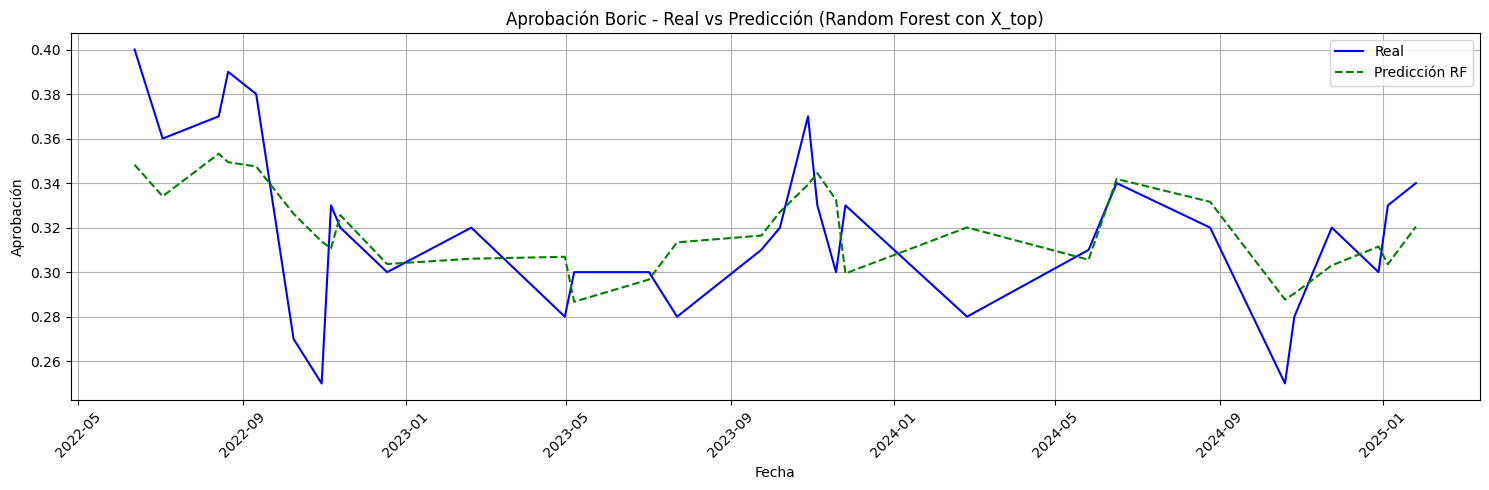

In [110]:
# Crear DataFrame con resultados
df_resultado = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_rf,
    'Predicción RF': y_pred_real_rf
}).sort_values('Fecha')  # ordenar cronológicamente

plt.figure(figsize=(15, 5))
plt.plot(df_resultado['Fecha'], df_resultado['Aprobación Real'], label='Real', color='blue')
plt.plot(df_resultado['Fecha'], df_resultado['Predicción RF'], label='Predicción RF', color='green', linestyle='--')
plt.title('Aprobación Boric - Real vs Predicción (Random Forest con X_top)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Veamos la calidad de la predicción analizando la calidad o importancia de las variables predictoras:

In [111]:
importancias = pd.DataFrame({
    'variable': X.columns,
    'importancia': modelo_rf.feature_importances_
}).sort_values(by='importancia', ascending=False)

print(importancias.head(15))

                           variable  importancia
787             approval_rolling_4w     0.046838
788                 approval_lag_1w     0.036809
702                  robertuito_695     0.015275
72                    robertuito_65     0.015000
5                         likeCount     0.013768
25                    robertuito_18     0.012971
784    weighted_positive_quoteCount     0.012891
654                  robertuito_647     0.012832
775  weighted_positive_retweetCount     0.011366
153                  robertuito_146     0.010638
380                  robertuito_373     0.010373
578                  robertuito_571     0.010060
497                  robertuito_490     0.009792
282                  robertuito_275     0.009578
209                  robertuito_202     0.009245


In [112]:
top_vars = [
    'approval_rolling_4w',
    'approval_lag_1w',
    'robertuito_695',
    'robertuito_65',
    'likeCount',
    'robertuito_18',
    'weighted_positive_quoteCount',
    'robertuito_647',
    'weighted_positive_retweetCount',
    'robertuito_146',
    'robertuito_373',
    'robertuito_571',
    'robertuito_490',
    'robertuito_275',
    'robertuito_202'
]

target = 'aprobacion_boric'
df_model = df_final.copy()
df_model = df_model.dropna(subset=top_vars + [target])  # Eliminar filas con NaN en las variables clave

X_top = df_model[top_vars]
y = df_model[target]
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_top)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

modelo_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
modelo_rf.fit(X_train, y_train)
y_pred = modelo_rf.predict(X_test)

# Desescalar
y_test_real_rf = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real_rf = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Métricas
mae = mean_absolute_error(y_test_real_rf, y_pred_real_rf)
r2 = r2_score(y_test_real_rf, y_pred_real_rf)

print(f"🌲 Random Forest con X_top - MAE: {mae:.4f}, R²: {r2:.4f}")

🌲 Random Forest con X_top - MAE: 0.0229, R²: 0.4436


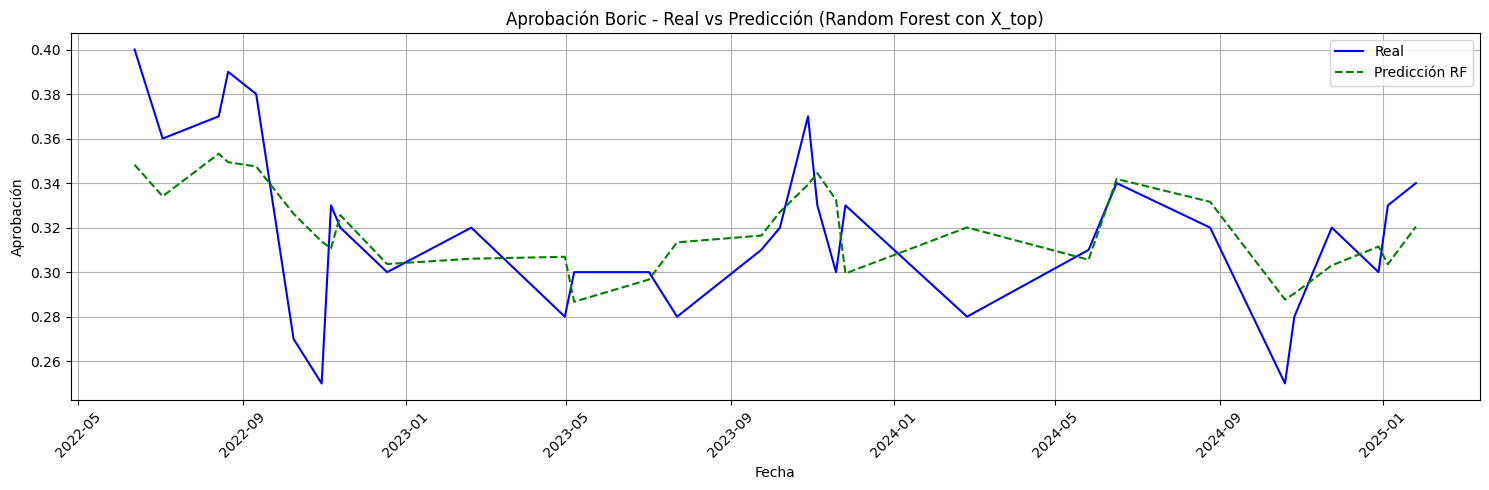

In [113]:
# Crear DataFrame con resultados
df_resultado = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_rf,
    'Predicción RF': y_pred_real_rf
}).sort_values('Fecha')  # ordenar cronológicamente

plt.figure(figsize=(15, 5))
plt.plot(df_resultado['Fecha'], df_resultado['Aprobación Real'], label='Real', color='blue')
plt.plot(df_resultado['Fecha'], df_resultado['Predicción RF'], label='Predicción RF', color='green', linestyle='--')
plt.title('Aprobación Boric - Real vs Predicción (Random Forest con X_top)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## XGBoost:

In [114]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=False)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"⚡ XGBoost - MAE: {mae_xgb:.2f}, R²: {r2_xgb:.2f}")

/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


⚡ XGBoost - MAE: 0.10, R²: 0.55


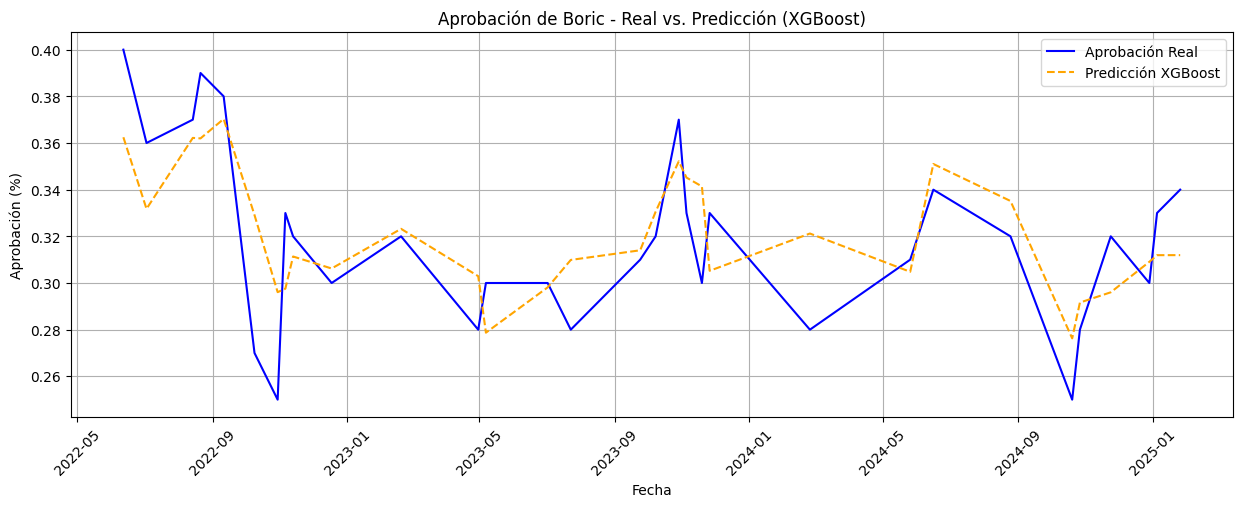

In [115]:
y_test_real_xgb = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real_xgb = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()

df_results = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_xgb,
    'Predicción XGBoost': y_pred_real_xgb
})


df_results = df_results.sort_values(by='Fecha')
plt.figure(figsize=(15, 5))
plt.plot(df_results['Fecha'], df_results['Aprobación Real'], linestyle='-', color='blue', label='Aprobación Real')
plt.plot(df_results['Fecha'], df_results['Predicción XGBoost'], linestyle='--', color='orange', label='Predicción XGBoost')
plt.title('Aprobación de Boric - Real vs. Predicción (XGBoost)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## KNN:

In [116]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')
knn_model.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred_knn = knn_model.predict(X_test_scaled)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"📊 KNN - MAE: {mae_knn:.4f}, R²: {r2_knn:.4f}")

📊 KNN - MAE: 0.1185, R²: 0.3717


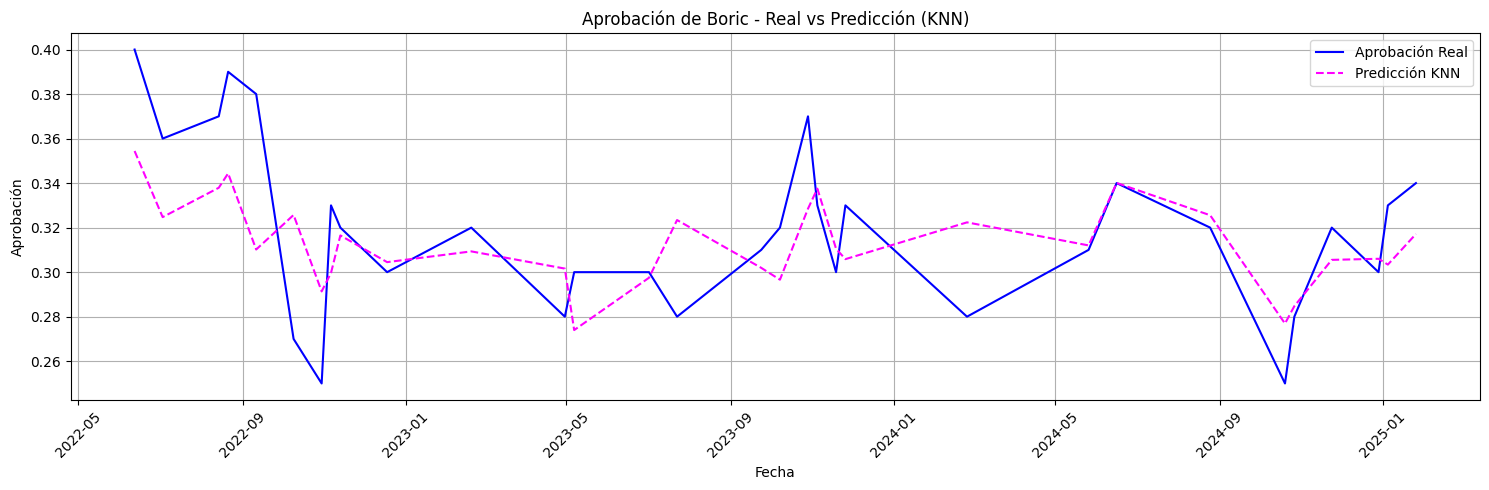

In [117]:
y_pred_real_knn = scaler_y.inverse_transform(y_pred_knn.reshape(-1, 1)).flatten()
y_test_real_knn = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

df_knn = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_knn,
    'Predicción KNN': y_pred_real_knn
}).sort_values('Fecha')

plt.figure(figsize=(15, 5))
plt.plot(df_knn['Fecha'], df_knn['Aprobación Real'], label='Aprobación Real', color='blue')
plt.plot(df_knn['Fecha'], df_knn['Predicción KNN'], label='Predicción KNN', color='magenta', linestyle='--')

plt.title('Aprobación de Boric - Real vs Predicción (KNN)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## MLP:

In [118]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # salida para regresión
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

y_pred = model.predict(X_test).flatten()
y_test_real_mlp = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real_mlp = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_real_mlp, y_pred_real_mlp)
r2 = r2_score(y_test_real_mlp, y_pred_real_mlp)

print(f"🤖 MLP - MAE: {mae:.4f}, R²: {r2:.4f}")

/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.4111 - val_loss: 0.0755
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1104 - val_loss: 0.1083
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1187 - val_loss: 0.0380
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0539 - val_loss: 0.0374
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0712 - val_loss: 0.0321
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0385 - val_loss: 0.0321
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0359 - val_loss: 0.0266
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0293 - val_loss: 0.0259
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0325 - val_loss: 0.0239
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0319 - val_loss: 0.0215
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0452 - val_loss: 0.0208
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0338 - val_l

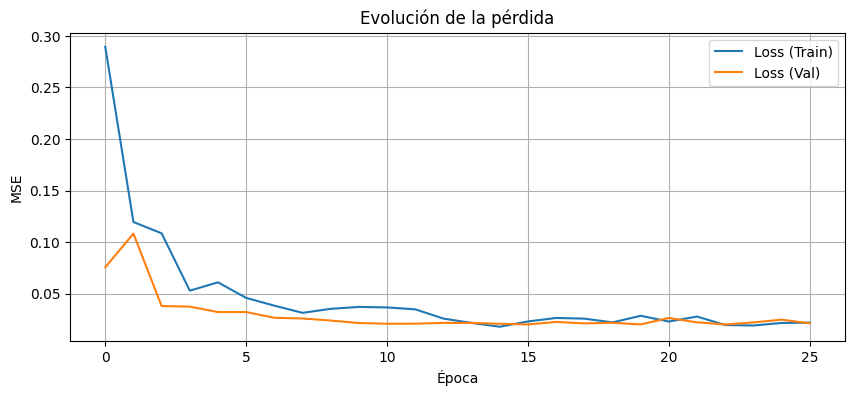

In [119]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Val)')
plt.title('Evolución de la pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

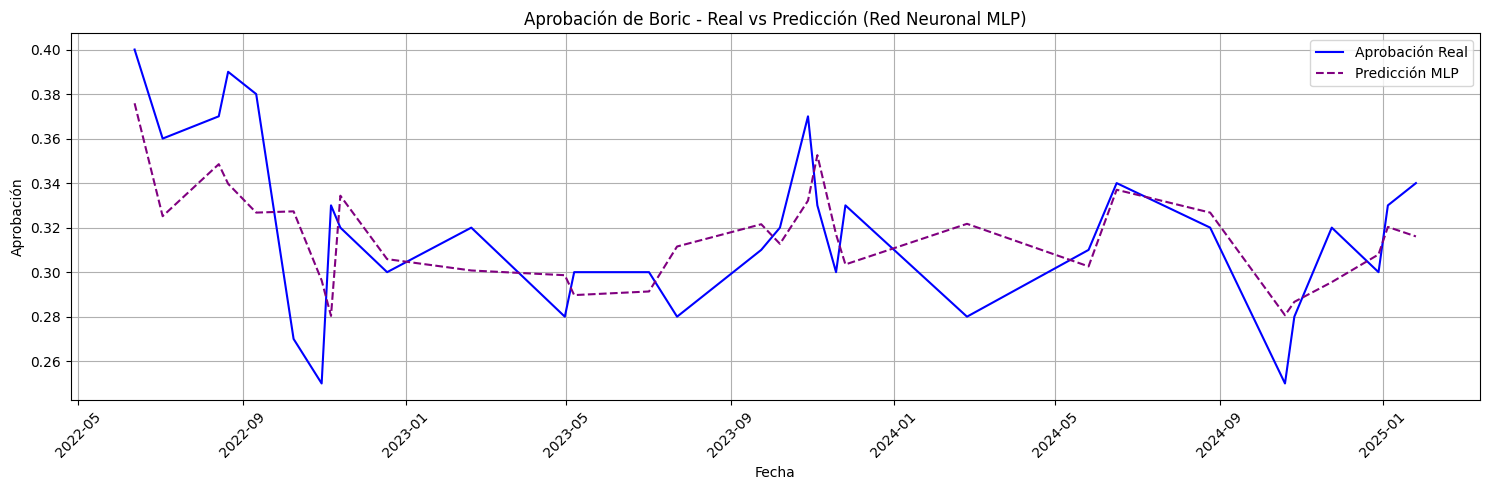

In [120]:
df_result_mlp = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_mlp,
    'Predicción MLP': y_pred_real_mlp
}).sort_values('Fecha')

plt.figure(figsize=(15, 5))
plt.plot(df_result_mlp['Fecha'], df_result_mlp['Aprobación Real'], label='Aprobación Real', color='blue')
plt.plot(df_result_mlp['Fecha'], df_result_mlp['Predicción MLP'], label='Predicción MLP', color='purple', linestyle='--')
plt.title('Aprobación de Boric - Real vs Predicción (Red Neuronal MLP)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Comparación de resultados:

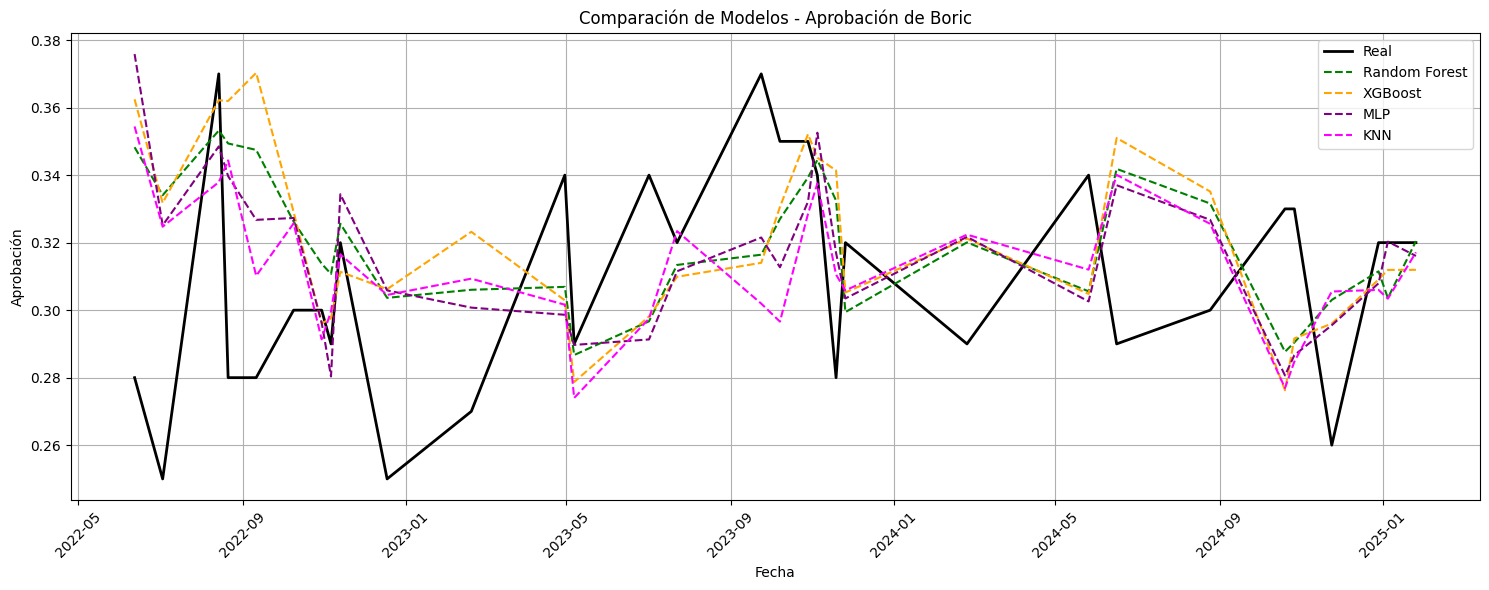

In [121]:
df_comparacion = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real,
    'Random Forest': y_pred_real_rf,
    'XGBoost': y_pred_real_xgb,
    'MLP': y_pred_real_mlp,
    'KNN': y_pred_real_knn
}).sort_values(by='Fecha')

plt.figure(figsize=(15, 6))
plt.plot(df_comparacion['Fecha'], df_comparacion['Aprobación Real'], label='Real', color='black', linewidth=2)
plt.plot(df_comparacion['Fecha'], df_comparacion['Random Forest'], label='Random Forest', linestyle='--', color='green')
plt.plot(df_comparacion['Fecha'], df_comparacion['XGBoost'], label='XGBoost', linestyle='--', color='orange')
plt.plot(df_comparacion['Fecha'], df_comparacion['MLP'], label='MLP', linestyle='--', color='purple')
plt.plot(df_comparacion['Fecha'], df_comparacion['KNN'], label='KNN', linestyle='--', color='magenta')

plt.title('Comparación de Modelos - Aprobación de Boric')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()